# Exemple pour reconnaissance des inondations

Petit exemple appris sur très peu d'images...

In [1]:
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_scoore
from sklearn.metrics import confusion_matrix

# Chargement des images

In [2]:
images = []
target = []
for repo in os.listdir("sample_labelled_train"):
    if repo.endswith("1"):
        target_ = 1
    else:
        target_= 0
    
    for image in os.listdir(os.path.join("sample_labelled_train", repo)):
        file_name = os.path.join("sample_labelled_train", repo, image)
        images.append(Image.open(file_name))
        target.append(target_)

# Recadrage des images en 224x224 

In [3]:
array_images = np.zeros((len(images), 224, 224, 3))

for _, image in enumerate(images):
    array_image = np.array(image)
    image_ = np.zeros((224, 224, 3))
    x_win = max(array_image.shape[0]//224, 1)
    y_win = max(array_image.shape[1]//224, 1)
    for x in range(224):
        for y in range(224):
            for z in range(3):
                if x*x_win < array_image.shape[0] and y*y_win < array_image.shape[1]:
                    image_[x, y, z] = int(np.max(array_image[x*x_win: (x+1)*x_win, y*y_win: (y+1)*y_win, z]))
                
    array_images[_, :, :, :] = image_

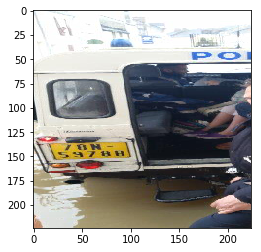

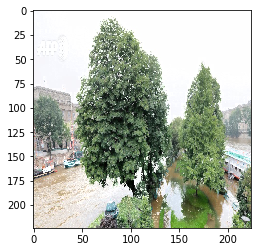

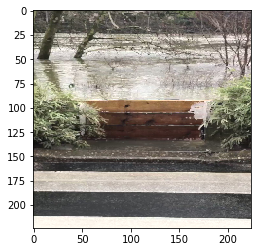

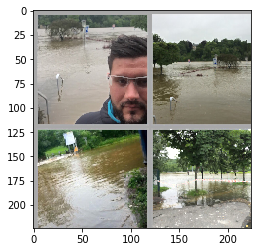

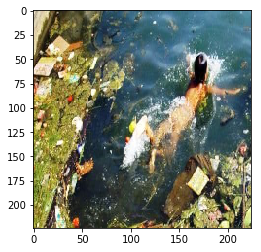

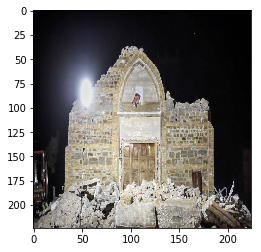

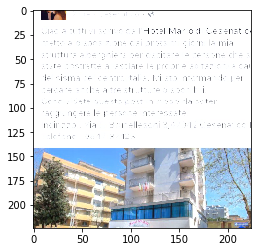

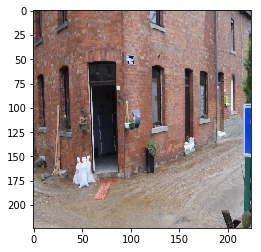

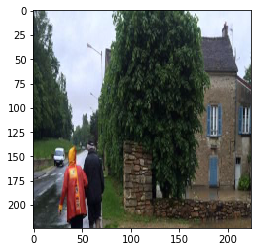

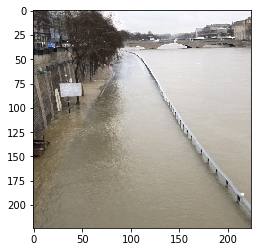

In [4]:
for _ in np.random.choice([i for i in range(len(images))], 10):
    plt.imshow(array_images[_,:,:,:].astype('int'))
    plt.show()

# Import de modèles pré-entrainés

In [5]:
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')
 
#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')
 
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')
 
#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

Using TensorFlow backend.


In [6]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, None, None, 1 258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, None, None, 1 576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, None, None, 1 0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, None, None, 1 147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, None, None, 1 258048      activation_74[0][0]              
__________

In [8]:
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

#  Utilisation des caractéristiques extraites par le modèle Vgg16 comme input pour un SVM

In [10]:
from keras.models import Model

intermediate_layer_model = Model(inputs=vgg_model.input,
                                 outputs=vgg_model.layers[-3].output)
intermediate_output = intermediate_layer_model.predict(array_images)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(intermediate_output, target)

In [12]:
clf = SVC(gamma='auto', kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
scores = []
for d in range(1, 5):
    clf = SVC(gamma='auto', kernel='poly', degree=d)
    scores_ = cross_val_score(clf, intermediate_output, target, cv=3, scoring='accuracy')
    scores.append(np.mean(scores_))

In [14]:
scores

[0.6474011826953004,
 0.6092903828197945,
 0.6002956738250856,
 0.6286025521319639]

In [15]:
scores = []
for d in range(1, 5):
    clf = SVC(gamma='auto', kernel='poly', degree=d)
    scores_ = cross_val_score(clf, intermediate_output, target, cv=3, scoring='roc_auc')
    scores.append(np.mean(scores_))

In [16]:
scores

[0.6855080409356725,
 0.6747149122807018,
 0.6644334795321637,
 0.6653252923976608]

In [17]:
clf = SVC(gamma='auto', kernel='poly', degree=1)
clf.fit(X_train, y_train)
confusion_matrix(clf.predict(X_test), y_test)

array([[9, 6],
       [4, 8]])